# Решение задачи регрессии точек с использованием модели YoloV5 и обучением по нескольким примерам

В ноутбуке проверяется подход к решению задачи регрессии ключевых точек с помощью построения модели регрессии на feature map предобученной модели

* получаем feature map с помощью модели YoloV5
* тренируем модели линейной регрессии решать задачу k-points

Использованы картинки из датасета https://www.kaggle.com/datasets/crawford/cat-dataset

In [1]:
import pathlib
import random
import sys

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm

sys.path.append("../yolov5")

In [2]:
from assh_utils import Batch

In [3]:
import os

root = "/home/asciishell/s3/asciishell-fsod/cats/CAT_00/"
images = [root + x for x in os.listdir(root) if x.endswith(".jpg")]
np.random.seed(42)
np.random.shuffle(images)
len(images)

1706

In [4]:
from models.common import AutoShape, DetectMultiBackend

In [5]:
model = AutoShape(DetectMultiBackend("./yolov5x.pt"))

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients, 205.7 GFLOPs
Adding AutoShape... 


In [6]:
%matplotlib inline

## Feature map visualisation

In [7]:
x = model(images[0], profile=pathlib.Path("vis"))

Saving vis/stage0_Conv_features.png... (32/80)
Saving vis/stage1_Conv_features.png... (32/160)
Saving vis/stage2_C3_features.png... (32/160)
Saving vis/stage3_Conv_features.png... (32/320)
Saving vis/stage4_C3_features.png... (32/320)
Saving vis/stage5_Conv_features.png... (32/640)
Saving vis/stage6_C3_features.png... (32/640)
Saving vis/stage7_Conv_features.png... (32/1280)
Saving vis/stage8_C3_features.png... (32/1280)
Saving vis/stage9_SPPF_features.png... (32/1280)
Saving vis/stage10_Conv_features.png... (32/640)
Saving vis/stage11_Upsample_features.png... (32/640)
Saving vis/stage12_Concat_features.png... (32/1280)
Saving vis/stage13_C3_features.png... (32/640)
Saving vis/stage14_Conv_features.png... (32/320)
Saving vis/stage15_Upsample_features.png... (32/320)
Saving vis/stage16_Concat_features.png... (32/640)
Saving vis/stage17_C3_features.png... (32/320)
Saving vis/stage18_Conv_features.png... (32/320)
Saving vis/stage19_Concat_features.png... (32/640)
Saving vis/stage20_C3_fea

We can fisualise feature map in the intermediate layers

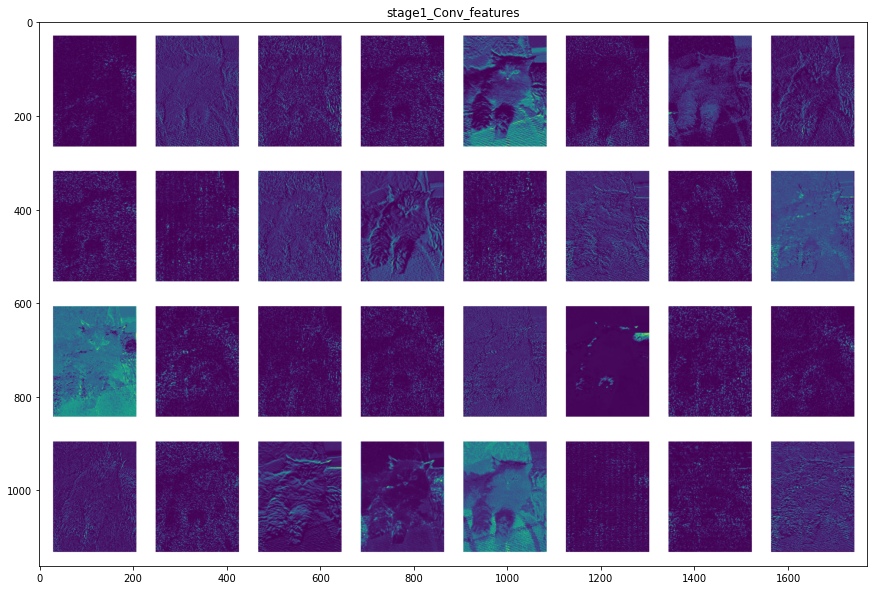

In [8]:
im = cv2.imread("vis/stage1_Conv_features.png", cv2.IMREAD_COLOR)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(25, 10))
plt.title("stage1_Conv_features")
plt.imshow(im)
plt.show()

Features are taken from 9th layer - last yolo backbone layer

see https://github.com/AsciiShell/yolov5/blob/master/models/yolov5x.yaml
```
# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]
```

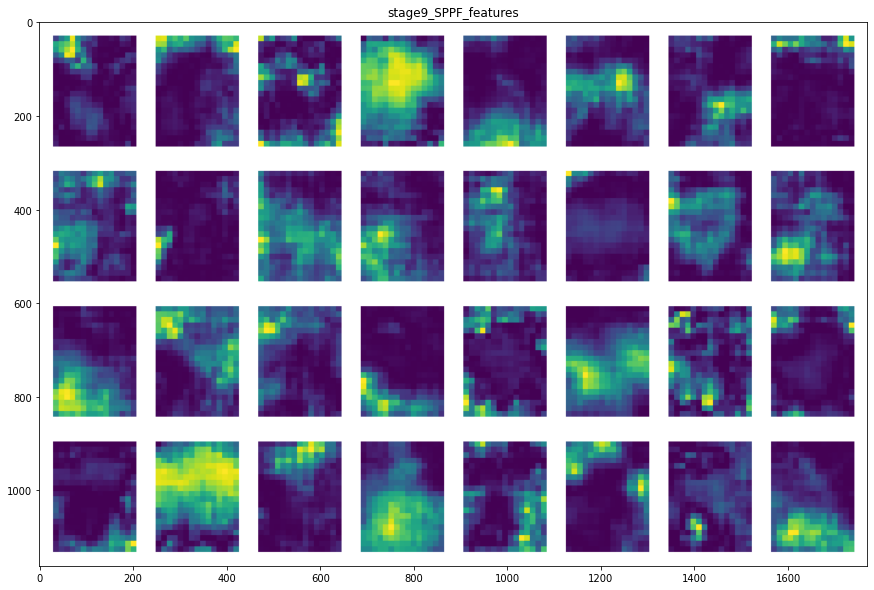

In [9]:
im = cv2.imread("vis/stage9_SPPF_features.png", cv2.IMREAD_COLOR)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(25, 10))
plt.title("stage9_SPPF_features")
plt.imshow(im)
plt.show()

## Model training

Для обучения будем брать центральный вектор из feature map + еще N - 1 ближайших векторов, где $N = (N_{neig} \cdot 2 + 1)^2$

Для каждого из N векторов target будет немного отличаться (k-points вычисляются осносительно центра выбранного вектора)

При инференсе реализован предикт для N векторов и усреднение предсказаний

In [8]:
for names in tqdm(Batch(images, 9)):
    # read images and data
    cat_names = names.copy()
    cat_target = []
    for cat_name in cat_names:
        with open(cat_name + ".cat") as f:
            cat_target.append([int(x) for x in f.read().split(" ")[1:-1]])
    cat_target = np.array(cat_target)
    cat_target = np.hstack([cat_target[:, ::2], cat_target[:, 1::2]])
    break

  0%|          | 0/190 [00:00<?, ?it/s]

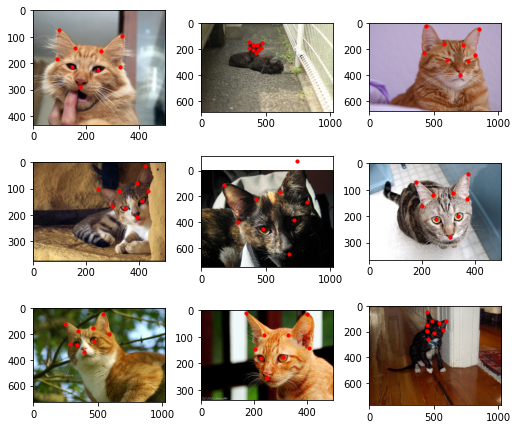

In [9]:
plt.figure(figsize=(7, 6), facecolor="w")
for i in range(len(cat_target)):
    plt.subplot(3, 3, i + 1)
    im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    plt.scatter(cat_target[i][:9], cat_target[i][9:], s=10, c="red")
plt.tight_layout(pad=0)
plt.show()

In [10]:
BATCH_SIZE = 32 # размер батча
TRAIN_SIZE = 16 # кол-во картинок в батче на обучение (с учетом валидационной)
VALID_SIZE = 8 # кол-во картинок для подбора опт. кол-ва PCA
FEATURE_MAP_SIZE = 32 # параметр модели
NUM_VEC = 3 # кол-во векторов для отступа

feature map Yolo для применения в батче и для одной картинки сильно отличается, поэтому будем заранее использовать препроцессор к картинке - чтобы размеры feature map совпадали для разных изображений

также аналогичный процессинг применяем и для kpoints

In [11]:
def letterbox(
    im, key_x, key_y, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32
):
    """
    source https://github.com/ultralytics/yolov5/blob/master/utils/augmentations.py#L91
    В функцию добавлено преобразование для kpoints
    """
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
        scale_x = shape[1] / new_unpad[0]
        scale_y = shape[0] / new_unpad[1]
        key_x = key_x / scale_x
        key_y = key_y / scale_y
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    key_x += left
    key_y += top
    return im, ratio, (dw, dh), (key_x, key_y)


def scale_coords(img1_shape, img0_shape, key_x, key_y):
    """
    source https://github.com/ultralytics/yolov5/blob/master/utils/general.py#L709
    Функция исправлена для применения преобразования к kpoints
    """
    # Rescale coords (xyxy) from img1_shape to img0_shape
    # calculate from img0_shape
    key_x = key_x.copy()
    key_y = key_y.copy()
    gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
    pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
    key_x -= pad[0]
    key_y -= pad[1]
    key_x /= gain
    key_y /= gain
    return key_x, key_y


def preproc_img(im, key_x, key_y):
    """
    Функция предобработки изображения
    Применение данной функции к каждому изображению позволяет
    получать feature map одинакового размера для всех изображений по отдельности
    (как если бы подавались все изображения в одном батче)
    """
    key_x = key_x.copy()
    key_y = key_y.copy()
    im = im.copy()
    res = letterbox(im, key_x, key_y, [640, 640, 32], auto=False)
    im, keys = res[0], res[-1]
    im = im.transpose((2, 0, 1))[::-1]
    im = np.ascontiguousarray(im)
    return im, keys[0], keys[1]

In [12]:
def predict(X, regr, inputs):
    """
    Получение, усреднение и обратное преобразование предсказаний
    """
    prediction = []
    output = regr.predict(X).reshape((-1, (NUM_VEC * 2 + 1) ** 2, 18))

    for i in range(len(output)):
        h = inputs[i]["height"]
        w = inputs[i]["width"]
        pred = []
        for fm in output[i]:
            x_output = fm[:9] * FEATURE_MAP_SIZE
            y_output = fm[9:] * FEATURE_MAP_SIZE
            x_output += (np.round(np.ceil(640 / FEATURE_MAP_SIZE) / 2) + 0.5) * FEATURE_MAP_SIZE
            y_output += (np.round(np.ceil(640 / FEATURE_MAP_SIZE) / 2) + 0.5) * FEATURE_MAP_SIZE
            key_x, key_y = scale_coords((640, 640), (h, w), x_output, y_output)
            pred.append(np.hstack([key_x, key_y]))
        prediction.append(np.array(pred).mean(axis=0))
    return prediction

## Базовый эксперимент

Выберем оптимальное кол-во PCA

In [12]:
metrics = []
for names in tqdm(Batch(images, BATCH_SIZE)):
    if len(names) < BATCH_SIZE:
        break
    # read images and data
    cat_names = names.copy()
    cat_target = []
    for cat_name in cat_names:
        with open(cat_name + ".cat") as f:
            cat_target.append([int(x) for x in f.read().split(" ")[1:-1]])
    cat_target = np.array(cat_target)
    cat_target = np.hstack([cat_target[:, ::2], cat_target[:, 1::2]])

    # make train and test datasets
    features_train = []
    features_test = []
    inputs = []
    target_train = []
    for i in range(len(cat_target)):
        im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
        height, width = im.shape[:2]
        inputs.append({"height": height, "width": width})

        # середина feature map
        x = round(np.ceil(640 / FEATURE_MAP_SIZE) / 2)
        y = round(np.ceil(640 / FEATURE_MAP_SIZE) / 2)

        im_, x_target, y_target = preproc_img(im, cat_target[i][:9], cat_target[i][9:])
        # apply model
        xx = model([im_])
        t = torch.load("tensor.pt")

        if i < TRAIN_SIZE:
            for x_ in range(x - NUM_VEC, x + NUM_VEC + 1):
                for y_ in range(y - NUM_VEC, y + NUM_VEC + 1):
                    features_train.append(np.array(t[0, :, y_ - 1, x_ - 1]))
                    x_center = FEATURE_MAP_SIZE * (x_ + 0.5)
                    y_center = FEATURE_MAP_SIZE * (y_ + 0.5)
                    target_train.append(
                        np.hstack([(x_target - x_center) / FEATURE_MAP_SIZE, (y_target - y_center) / FEATURE_MAP_SIZE])
                    )

        for x_ in range(x - NUM_VEC, x + NUM_VEC + 1):
            for y_ in range(y - NUM_VEC, y + NUM_VEC + 1):
                features_test.append(np.array(t[0, :, y_ - 1, x_ - 1]))

    features_train = np.array(features_train)
    features_test = np.array(features_test)

    # fit regression
    prange = np.unique(np.logspace(0, 1.9, 20).astype(int))
    for p in prange:
        pca = PCA(p, random_state=42)
        pca_train = pca.fit_transform(features_train)
        regr = LinearRegression().fit(pca_train, target_train)

        # predict key points
        pca_test = pca.transform(features_test)
        prediction = predict(pca_test, regr, inputs)

        metrics.append(
            [
                p,
                mean_squared_error(cat_target[:TRAIN_SIZE], prediction[:TRAIN_SIZE], squared=False),
                mean_squared_error(cat_target[TRAIN_SIZE:], prediction[TRAIN_SIZE:], squared=False),
                r2_score(cat_target[:TRAIN_SIZE], prediction[:TRAIN_SIZE]),
                r2_score(cat_target[TRAIN_SIZE:], prediction[TRAIN_SIZE:]),
            ]
        )

    break

  0%|          | 0/54 [00:13<?, ?it/s]


In [13]:
features_train.shape

(784, 1280)

In [14]:
t.shape

torch.Size([1, 1280, 20, 20])

In [15]:
metrics = pd.DataFrame(metrics, columns=["pca_cnt", "train_rmse", "test_rmse", "train_r2", "test_r2"])
metrics

,pca_cnt,train_rmse,test_rmse,train_r2,test_r2
0,1,83.432551,84.824778,0.390675,0.324221
1,2,79.202452,86.692369,0.492098,0.290428
2,3,72.933986,87.072969,0.536037,0.318790
3,5,65.218888,81.189833,0.627711,0.452732
4,6,62.608392,77.282311,0.682170,0.516342
5,7,46.483229,80.227530,0.807552,0.495791
6,9,35.093008,78.847790,0.891568,0.509940
7,12,28.287435,77.814612,0.936978,0.522427
8,15,22.714284,77.008469,0.958401,0.517733
9,19,15.385033,77.639306,0.982909,0.518253


In [16]:
metrics.to_csv("kpoints_results/pca_base_experiment.csv")

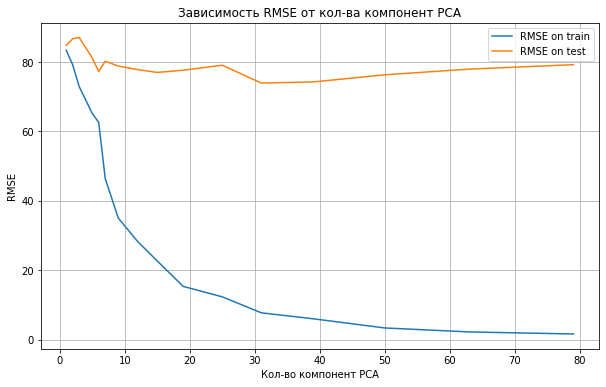

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(metrics["pca_cnt"], metrics["train_rmse"], label="RMSE on train")
plt.plot(metrics["pca_cnt"], metrics["test_rmse"], label="RMSE on test")
plt.title("Зависимость RMSE от кол-ва компонент PCA")
plt.ylabel("RMSE")
plt.xlabel("Кол-во компонент PCA")
plt.legend()
plt.grid()
plt.show()

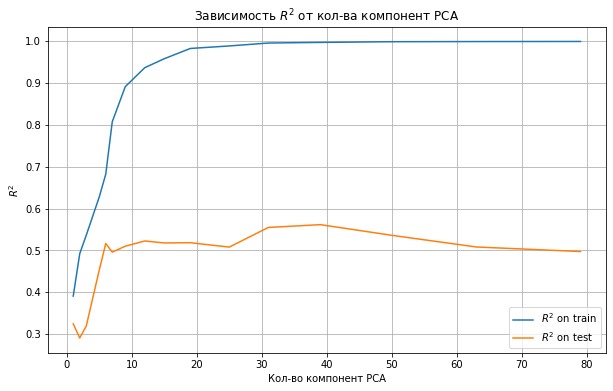

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(metrics["pca_cnt"], metrics["train_r2"], label="$R^2$ on train")
plt.plot(metrics["pca_cnt"], metrics["test_r2"], label="$R^2$ on test")
plt.title("Зависимость $R^2$ от кол-ва компонент PCA")
plt.ylabel("$R^2$")
plt.xlabel("Кол-во компонент PCA")
plt.legend()
plt.grid()
plt.show()

In [19]:
metrics = []
for names in tqdm(Batch(images, BATCH_SIZE)):
    if len(names) < BATCH_SIZE:
        break
    # read images and data
    cat_names = names.copy()
    cat_target = []
    for cat_name in cat_names:
        with open(cat_name + ".cat") as f:
            cat_target.append([int(x) for x in f.read().split(" ")[1:-1]])
    cat_target = np.array(cat_target)
    cat_target = np.hstack([cat_target[:, ::2], cat_target[:, 1::2]])

    # make train and test datasets
    features_train = []
    features_test = []
    inputs = []
    target_train = []
    for i in range(len(cat_target)):
        im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
        height, width = im.shape[:2]
        inputs.append({"height": height, "width": width})

        # середина feature map
        x = round(np.ceil(640 / FEATURE_MAP_SIZE) / 2)
        y = round(np.ceil(640 / FEATURE_MAP_SIZE) / 2)

        im_, x_target, y_target = preproc_img(im, cat_target[i][:9], cat_target[i][9:])
        # apply model
        xx = model([im_])
        t = torch.load("tensor.pt")

        if i < TRAIN_SIZE:
            for x_ in range(x - NUM_VEC, x + NUM_VEC + 1):
                for y_ in range(y - NUM_VEC, y + NUM_VEC + 1):
                    features_train.append(np.array(t[0, :, y_ - 1, x_ - 1]))
                    x_center = FEATURE_MAP_SIZE * (x_ + 0.5)
                    y_center = FEATURE_MAP_SIZE * (y_ + 0.5)
                    target_train.append(
                        np.hstack([(x_target - x_center) / FEATURE_MAP_SIZE, (y_target - y_center) / FEATURE_MAP_SIZE])
                    )

        for x_ in range(x - NUM_VEC, x + NUM_VEC + 1):
            for y_ in range(y - NUM_VEC, y + NUM_VEC + 1):
                features_test.append(np.array(t[0, :, y_ - 1, x_ - 1]))

    features_train = np.array(features_train)
    features_test = np.array(features_test)

    # fit regression
    pca_metrics = []
    prange = np.unique(np.logspace(0, 1.9, 20).astype(int))
    for p in prange:
        if p > features_train.shape[0]:
            break
        pca = PCA(p, random_state=42)
        n_ind = int(features_train.shape[0] / TRAIN_SIZE)
        pca_train = pca.fit_transform(features_train[: -n_ind * VALID_SIZE])
        regr = LinearRegression().fit(pca_train, target_train[: -n_ind * VALID_SIZE])

        # predict key points
        pca_test = pca.transform(features_test)
        prediction = predict(pca_test, regr, inputs)

        pca_metrics.append(
            mean_squared_error(
                cat_target[TRAIN_SIZE - VALID_SIZE : TRAIN_SIZE],
                prediction[TRAIN_SIZE - VALID_SIZE : TRAIN_SIZE],
                squared=False,
            )
        )

    n_pca = prange[np.argmin(pca_metrics)]

    # fit regression
    pca = PCA(n_pca, random_state=42)
    pca_train = pca.fit_transform(features_train)
    regr = LinearRegression().fit(pca_train, target_train)

    # predict key points
    pca_test = pca.transform(features_test)
    prediction = predict(pca_test, regr, inputs)

    metrics.append(
        [
            n_pca,
            mean_squared_error(cat_target[:TRAIN_SIZE], prediction[:TRAIN_SIZE], squared=False),
            mean_squared_error(cat_target[TRAIN_SIZE:], prediction[TRAIN_SIZE:], squared=False),
            r2_score(cat_target[:TRAIN_SIZE], prediction[:TRAIN_SIZE]),
            r2_score(cat_target[TRAIN_SIZE:], prediction[TRAIN_SIZE:]),
        ]
    )

 98%|█████████▊| 53/54 [12:30<00:14, 14.16s/it]


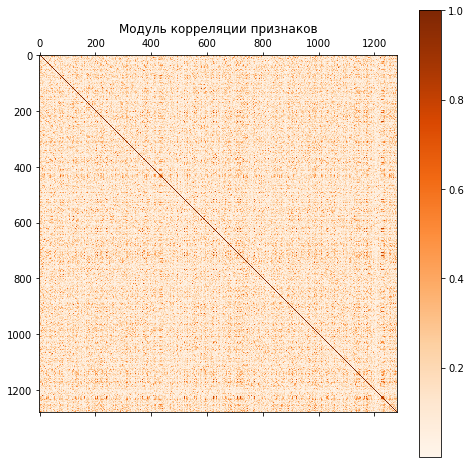

In [20]:
plt.figure(figsize=(8, 8))
plt.matshow(np.abs(np.corrcoef(features_train, rowvar=False)), cmap="Oranges", fignum=1)
plt.title("Модуль корреляции признаков")
plt.colorbar()
plt.show()

In [21]:
metrics = pd.DataFrame(metrics, columns=["n_pca", "train_rmse", "test_rmse", "train_r2", "test_r2"])
metrics.describe(percentiles=[])

,n_pca,train_rmse,test_rmse,train_r2,test_r2
count,53.000000,53.000000,53.000000,53.000000,53.000000
mean,17.716981,39.943551,83.792971,0.809430,0.457324
std,20.803455,28.685180,21.792163,0.188417,0.203933
min,1.000000,1.394288,50.732582,0.353993,-0.448652
50%,9.000000,40.407883,79.537078,0.872965,0.497951
max,79.000000,98.688134,158.257659,0.999900,0.775078


In [22]:
metrics.to_csv("kpoints_results/batch_pca_best_base_experiment.csv")

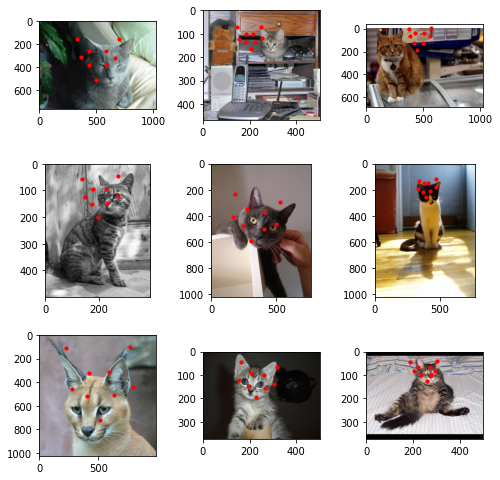

In [23]:
plt.figure(figsize=(7, 7), facecolor="w")
for i in range(9):
    plt.subplot(3, 3, i + 1)
    im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    plt.scatter(prediction[i][:9], prediction[i][9:], s=10, c="red")
plt.tight_layout()
plt.show()

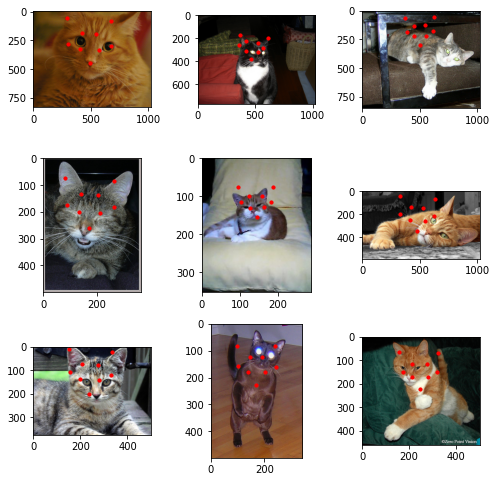

In [24]:
plt.figure(figsize=(7, 7), facecolor="w")
for i in range(9):
    plt.subplot(3, 3, i + 1)
    i = BATCH_SIZE - 9 + i
    im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    plt.scatter(prediction[i][:9], prediction[i][9:], s=10, c="red")
plt.tight_layout()
plt.show()

Близкие вектора feature map действительно сильно коррелируют между собой

(1280, 3, 3)


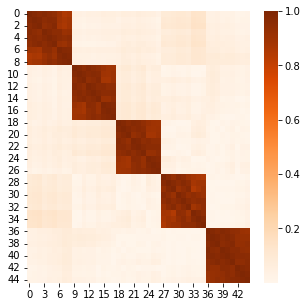

In [25]:
f = t[0, :, y - 1 : y + 2, x - 1 : x + 2].detach().numpy()
print(f.shape)
f = f.reshape((256, -1))
f = np.abs(pd.DataFrame(f).corr())
plt.figure(figsize=(5, 5), facecolor="w")
sns.heatmap(f, cmap=plt.cm.Oranges);

In [26]:
np.array(features_train).shape, np.array(target_train).shape

((784, 1280), (784, 18))

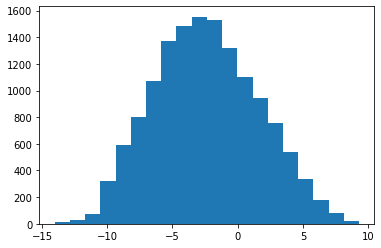

In [27]:
plt.hist(np.array(target_train).ravel(), bins=20);

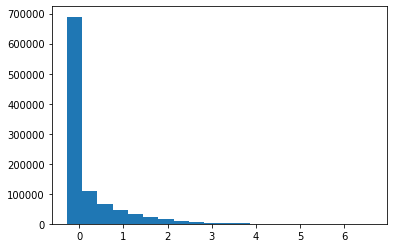

In [28]:
plt.hist(np.array(features_train).ravel(), bins=20);

## Augmentations

Исследуем влияние аугментации на решение задачи kpoints
* Наличие аугментаций с цветом и яркостью
* Наличие аугментаций с поворотом
* Наличие аугментаций с кропом
* Кол-во аугментаций

In [30]:
def fit_pca(rotate_flag, crop_flag, n_aug):
    transform1_compose = [
        A.HueSaturationValue(p=1),
        A.RandomBrightnessContrast(p=1),
    ]
    if rotate_flag:
        transform1_compose.append(A.Rotate(limit=15, p=1))
    transform1 = A.Compose(
        transform1_compose,
        keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
    )

    transform2_compose = [
        A.RGBShift(p=1),
        A.RandomBrightnessContrast(p=1),
    ]
    if rotate_flag:
        transform2_compose.append(A.ShiftScaleRotate(rotate_limit=15, p=1))
    transform2 = A.Compose(
        transform2_compose,
        keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
    )

    metrics = []
    for names in tqdm(Batch(images, BATCH_SIZE)):
        if len(names) < BATCH_SIZE:
            break
        # read images and data
        cat_names = names.copy()
        cat_target = []
        for cat_name in cat_names:
            with open(cat_name + ".cat") as f:
                cat_target.append([int(x) for x in f.read().split(" ")[1:-1]])
        cat_target = np.array(cat_target)
        cat_target = np.hstack([cat_target[:, ::2], cat_target[:, 1::2]])

        # make train and test datasets
        features_train = []
        features_test = []
        inputs = []
        target_train = []
        for i in range(len(cat_target)):
            im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
            height, width = im.shape[:2]
            inp = [{"height": height, "width": width}]
            inputs.append(inp[0])

            # середина feature map
            x = round(np.ceil(640 / FEATURE_MAP_SIZE) / 2)
            y = round(np.ceil(640 / FEATURE_MAP_SIZE) / 2)

            im_, key_x, key_y = preproc_img(im, cat_target[i][:9], cat_target[i][9:])
            # apply model
            xx = model([im_])
            t = torch.load("tensor.pt")

            if i < TRAIN_SIZE:
                imgs = []
                cat_targets = [np.hstack([key_x, key_y])]
                kp_target = list(zip(cat_target[i][:9], cat_target[i][9:]))

                transform3 = A.Compose(
                    [
                        A.RandomSizedCrop(
                            min_max_height=(int(min(height, width) * 0.9), min(height, width)),
                            height=height,
                            width=width,
                            p=1,
                        ),
                        # A.OneOf([A.Rotate(p=0.8), A.ShiftScaleRotate(p=0.8)], p=1),
                        A.OneOf([A.HueSaturationValue(p=1), A.RGBShift(p=1)], p=1),
                        A.RandomBrightnessContrast(p=1),
                    ],
                    keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
                )

                for seed in range(n_aug):
                    random.seed(seed)
                    transformed = transform1(image=im, keypoints=kp_target)
                    kp = np.array(transformed["keypoints"])
                    im_, key_x, key_y = preproc_img(transformed["image"], kp[:, 0], kp[:, 1])
                    imgs.append(im_)
                    cat_targets.append(np.hstack([key_x, key_y]))

                    transformed = transform2(image=im, keypoints=kp_target)
                    kp = np.array(transformed["keypoints"])
                    im_, key_x, key_y = preproc_img(transformed["image"], kp[:, 0], kp[:, 1])
                    imgs.append(im_)
                    cat_targets.append(np.hstack([key_x, key_y]))

                    if crop_flag:
                        transformed = transform3(image=im, keypoints=kp_target)
                        kp = np.array(transformed["keypoints"])
                        im_, key_x, key_y = preproc_img(transformed["image"], kp[:, 0], kp[:, 1])
                        imgs.append(im_)
                        cat_targets.append(np.hstack([key_x, key_y]))

                # apply model
                xx = model(imgs)
                tt = torch.load("tensor.pt")
                tt = torch.cat((t, tt))

                for j in range(tt.shape[0]):
                    for x_ in range(x - NUM_VEC, x + NUM_VEC + 1):
                        for y_ in range(y - NUM_VEC, y + NUM_VEC + 1):
                            x_target = cat_targets[j][:9]
                            y_target = cat_targets[j][9:]
                            features_train.append(np.array(tt[j, :, y_ - 1, x_ - 1]))
                            x_center = FEATURE_MAP_SIZE * (x_ + 0.5)
                            y_center = FEATURE_MAP_SIZE * (y_ + 0.5)
                            target_train.append(
                                np.hstack(
                                    [(x_target - x_center) / FEATURE_MAP_SIZE, (y_target - y_center) / FEATURE_MAP_SIZE]
                                )
                            )

            for x_ in range(x - NUM_VEC, x + NUM_VEC + 1):
                for y_ in range(y - NUM_VEC, y + NUM_VEC + 1):
                    features_test.append(np.array(t[0, :, y_ - 1, x_ - 1]))

        features_train = np.array(features_train)
        features_test = np.array(features_test)

        # fit regression
        pca_metrics = []
        prange = np.unique(np.logspace(0, 1.9, 20).astype(int))
        n_ind = int(features_train.shape[0] / TRAIN_SIZE)
        for p in prange:
            if p > features_train.shape[0] - n_ind * VALID_SIZE:
                break
            pca = PCA(p, random_state=42)
            pca_train = pca.fit_transform(features_train[: -n_ind * VALID_SIZE])
            regr = LinearRegression().fit(pca_train, target_train[: -n_ind * VALID_SIZE])

            # predict key points
            pca_test = pca.transform(features_test)
            prediction = predict(pca_test, regr, inputs)

            pca_metrics.append(
                mean_squared_error(
                    cat_target[TRAIN_SIZE - VALID_SIZE : TRAIN_SIZE],
                    prediction[TRAIN_SIZE - VALID_SIZE : TRAIN_SIZE],
                    squared=False,
                )
            )

        n_pca = prange[np.argmin(pca_metrics)]

        # fit regression
        pca = PCA(n_pca, random_state=42)
        pca_train = pca.fit_transform(features_train)
        regr = LinearRegression().fit(pca_train, target_train)

        # predict key points
        pca_test = pca.transform(features_test)
        prediction = predict(pca_test, regr, inputs)

        metrics.append(
            [
                n_pca,
                mean_squared_error(cat_target[:TRAIN_SIZE], prediction[:TRAIN_SIZE], squared=False),
                mean_squared_error(cat_target[TRAIN_SIZE:], prediction[TRAIN_SIZE:], squared=False),
                r2_score(cat_target[:TRAIN_SIZE], prediction[:TRAIN_SIZE]),
                r2_score(cat_target[TRAIN_SIZE:], prediction[TRAIN_SIZE:]),
            ]
        )
    return metrics

In [29]:
np.arange(6)[:-2]

array([0, 1, 2, 3])

### Эксперимент 1

In [30]:
metrics = fit_pca(rotate_flag=False, crop_flag=False, n_aug=1)

 98%|█████████▊| 53/54 [21:51<00:24, 24.75s/it]


In [31]:
metrics = pd.DataFrame(metrics, columns=["n_pca", "train_rmse", "test_rmse", "train_r2", "test_r2"])
metrics.describe(percentiles=[])

,n_pca,train_rmse,test_rmse,train_r2,test_r2
count,53.000000,53.000000,53.000000,53.000000,53.000000
mean,18.264151,42.428405,84.196933,0.798569,0.454472
std,23.412810,27.786886,21.904697,0.185351,0.198082
min,1.000000,4.665338,49.767008,0.345938,-0.429894
50%,7.000000,49.503062,78.840720,0.813536,0.492836
max,79.000000,98.915186,160.616836,0.998583,0.768556


In [32]:
metrics.to_csv("kpoints_results/batch_pca_best_experiment_1.csv")

### Эксперимент 2

In [33]:
metrics = fit_pca(rotate_flag=True, crop_flag=False, n_aug=1)

 98%|█████████▊| 53/54 [22:16<00:25, 25.22s/it]


In [34]:
metrics = pd.DataFrame(metrics, columns=["n_pca", "train_rmse", "test_rmse", "train_r2", "test_r2"])
metrics.describe(percentiles=[])

,n_pca,train_rmse,test_rmse,train_r2,test_r2
count,53.000000,53.000000,53.000000,53.000000,53.000000
mean,22.849057,38.608094,84.985832,0.833119,0.442726
std,24.335315,26.131696,21.621398,0.166832,0.220314
min,1.000000,7.860090,49.487211,0.485138,-0.580164
50%,12.000000,31.158390,81.181339,0.919849,0.458002
max,79.000000,97.767910,153.934147,0.996135,0.772874


In [35]:
metrics.to_csv("kpoints_results/batch_pca_best_experiment_2.csv")

### Эксперимент 3

In [36]:
metrics = fit_pca(rotate_flag=True, crop_flag=True, n_aug=1)

 98%|█████████▊| 53/54 [27:29<00:31, 31.12s/it]


In [37]:
metrics = pd.DataFrame(metrics, columns=["n_pca", "train_rmse", "test_rmse", "train_r2", "test_r2"])
metrics.describe(percentiles=[])

,n_pca,train_rmse,test_rmse,train_r2,test_r2
count,53.000000,53.000000,53.000000,53.000000,53.000000
mean,22.679245,39.928778,85.950404,0.820860,0.441147
std,26.022013,24.032492,21.173820,0.174232,0.187299
min,1.000000,9.911555,50.900077,0.401774,-0.142277
50%,12.000000,36.882495,84.948944,0.903024,0.452858
max,79.000000,87.953288,157.017298,0.991987,0.757483


In [38]:
metrics.to_csv("kpoints_results/batch_pca_best_experiment_3.csv")

### Эксперимент 4

In [ ]:
prange = np.unique(np.logspace(0, 1.2, 10).astype(int))
results = []
for p in prange:
    metrics = fit_pca(rotate_flag=True, crop_flag=False, n_aug=p)
    metrics = pd.DataFrame(metrics, columns=["n_pca", "train_rmse", "test_rmse", "train_r2", "test_r2"])
    res = {
        "n_pca_mean": metrics["n_pca"].median(),
        "train_rmse_mean": metrics["train_rmse"].mean(),
        "test_rmse_mean": metrics["test_rmse"].mean(),
        "train_rmse_std": metrics["train_rmse"].std(),
        "test_rmse_std": metrics["test_rmse"].std(),
        "train_r2_mean": metrics["train_r2"].mean(),
        "test_r2_mean": metrics["test_r2"].mean(),
        "train_r2_std": metrics["train_r2"].std(),
        "test_r2_std": metrics["test_r2"].std(),
        "aug_cnt": p,
    }
    results.append(res)

In [40]:
results = pd.DataFrame(results)
results

,n_pca_mean,train_rmse_mean,test_rmse_mean,train_rmse_std,test_rmse_std,train_r2_mean,test_r2_mean,train_r2_std,test_r2_std,aug_cnt
0,12.0,38.608094,84.985832,26.131696,21.621398,0.833119,0.442726,0.166832,0.220314,1
1,9.0,41.850061,85.110341,27.206881,21.720628,0.804985,0.432840,0.184639,0.227004,2
2,9.0,42.062265,84.371012,25.691067,20.964055,0.810489,0.448965,0.173260,0.210230,3
3,9.0,42.289833,84.288564,26.276761,21.424434,0.808563,0.450368,0.175948,0.209402,4
4,9.0,40.211416,84.793665,26.043052,21.474170,0.824791,0.445349,0.170564,0.209981,6


In [41]:
results.to_csv("kpoints_results/experiment_4.csv")

## Минимальное кол-во изображений обучающей выборки для решений задачи kpoints

In [ ]:
prange = np.unique(np.logspace(0, 1.2, 10).astype(int))
results = []
for p in prange[3:]:
    TRAIN_SIZE = p
    VALID_SIZE = p - int(p / 2 + 0.5)
    metrics = fit_pca(rotate_flag=True, crop_flag=False, n_aug=1)
    metrics = pd.DataFrame(metrics, columns=["n_pca", "train_rmse", "test_rmse", "train_r2", "test_r2"])
    res = {
        "n_pca_mean": metrics["n_pca"].median(),
        "train_rmse_mean": metrics["train_rmse"].mean(),
        "test_rmse_mean": metrics["test_rmse"].mean(),
        "train_rmse_std": metrics["train_rmse"].std(),
        "test_rmse_std": metrics["test_rmse"].std(),
        "train_r2_mean": metrics["train_r2"].mean(),
        "test_r2_mean": metrics["test_r2"].mean(),
        "train_r2_std": metrics["train_r2"].std(),
        "test_r2_std": metrics["test_r2"].std(),
        "train_size": p,
    }
    results.append(res)

 78%|███████▊  | 42/54 [20:26<06:00, 30.04s/it]

In [36]:
results = pd.DataFrame(results)
results

,Unnamed: 0,n_pca_mean,train_rmse_mean,test_rmse_mean,train_rmse_std,...,train_r2_mean,test_r2_mean,train_r2_std,test_r2_std,train_size
0,0,7.0,14.985018,92.981868,14.244110,...,0.812183,0.344519,0.456568,0.253321,4
1,1,7.0,25.559446,89.418359,24.008698,...,0.835783,0.401417,0.249170,0.176632,6
2,2,12.0,30.810882,88.482683,28.697417,...,0.813417,0.412267,0.278958,0.187692,8
3,3,9.0,32.148920,87.586874,24.061374,...,0.837176,0.430932,0.211248,0.156539,11
4,4,12.0,38.242185,85.648041,26.493878,...,0.824286,0.431435,0.178783,0.203172,15


In [ ]:
results.to_csv("kpoints_results/experiment_5.csv")

## Оптимальное кол-во векторов feature map для решения задачи kpoints

In [14]:
TRAIN_SIZE = 16
VALID_SIZE = 8

In [31]:
results = []
for p in np.arange(6):
    NUM_VEC = p
    metrics = fit_pca(rotate_flag=True, crop_flag=False, n_aug=1)
    metrics = pd.DataFrame(metrics, columns=["n_pca", "train_rmse", "test_rmse", "train_r2", "test_r2"])
    res = {
        "n_pca_mean": metrics["n_pca"].median(),
        "train_rmse_mean": metrics["train_rmse"].mean(),
        "test_rmse_mean": metrics["test_rmse"].mean(),
        "train_rmse_std": metrics["train_rmse"].std(),
        "test_rmse_std": metrics["test_rmse"].std(),
        "train_r2_mean": metrics["train_r2"].mean(),
        "test_r2_mean": metrics["test_r2"].mean(),
        "train_r2_std": metrics["train_r2"].std(),
        "test_r2_std": metrics["test_r2"].std(),
        "num_vec": p,
    }
    results.append(res)

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

In [34]:
results = pd.DataFrame(results)
results

,n_pca_mean,train_rmse_mean,test_rmse_mean,train_rmse_std,test_rmse_std,train_r2_mean,test_r2_mean,train_r2_std,test_r2_std,num_vec
0,6.0,42.475671,84.551757,27.493192,20.612075,0.779392,0.445912,0.210537,0.186157,0
1,19.0,24.730875,83.170246,25.322430,21.893926,0.899759,0.474790,0.164385,0.189534,1
2,12.0,35.882573,83.286262,26.782992,20.907674,0.837846,0.464379,0.184591,0.185168,2
3,12.0,38.608096,84.985834,26.131696,21.621399,0.833119,0.442726,0.166832,0.220314,3
4,6.0,47.360477,86.406813,27.513362,21.955771,0.762763,0.415784,0.190059,0.228887,4
5,5.0,52.864271,87.383151,25.741349,22.009303,0.714852,0.399391,0.200555,0.218023,5


In [35]:
results.to_csv("kpoints_results/experiment_6.csv")